# AnimeGM - Autoencoder
GOAL: Generate new anime-style images
    
Methodology:
1. Build a dataset of images suitable for out needs
2. Build a generative model.
3. Train the model
4. Generate a new image with random numbers
5. Transfer style to a photo
6. Examine results

## 1. Build a dataset
Pull in an existing dataset and modify it for my needs.

Lets start with the danbooru 2017 anime image dataset. Now this dataset is huge. So we are only going to use 1 torrent of the SFW subset.

### Imports

In [34]:
import pandas as pd
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import seaborn as sns; sns.set()
from skimage.transform import resize
from os import listdir
from os.path import join
from skimage import data
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
%matplotlib inline

### Functions

In [2]:
def gray_scale_resize(image, resize_dim):
    # convert image to grayscale
    # same computation while we experiment
    gray_image = color.rgb2gray(image)
    
    # Resize the image down to 128x128
    resized_image = resize(gray_image, (resize_dim, resize_dim))
    
    return resized_image

In [3]:
def load_images(paths_list, n_images, resize_dim):
    # slice paths list to the amount we want
    slice_paths_list = paths_list[:n_images]

    # create an array for images
    images = np.zeros((n_images, resize_dim, resize_dim), dtype=np.float32)
        
    for i, image_path in enumerate(slice_paths_list): 
        # read image
        image = misc.imread(join(path, image_path))

        # rescale image
        images[i] = gray_scale_resize(image, resize_dim)
        
    return images

In [4]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
def show_images(images, figsize=(10, 10)):
    # get the number of images
    n_images = images.shape[0]
    # get the square root of the number of images
    squareroot = int(np.ceil(np.sqrt(n_images)))
    
    fig, ax = plt.subplots(squareroot, squareroot, figsize=figsize,
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i, axi in enumerate(ax.flat):
        # exit if the index of subplots is greater than amount of images
        if i >= n_images:
            return
        im = axi.imshow(images[i], cmap='gray')

In [6]:
def get_batch(batch_size, images):
    np.random.RandomState(0)
    
    # get shape of images
    images_shape = images.shape
    
    # create a range based on number of images
    images_range = np.arange(0, images_shape[0])
    
    # pick n batch_size random elements from images range
    random_indices = np.random.choice(images_range, batch_size, replace=False)
    
    # use random indices to grab a batch from images
    random_elements = images[random_indices]
    
    return random_elements

In [7]:
# get the normalized image
def preprocess(images, mean_image, std_dev_image):
    norm_image = (images - mean_image) / std_dev_image
    return norm_image

In [8]:
# remove normalization
def deprocess(norm_image, mean_image, std_dev_image):
    denorm_image =  (norm_image * std_dev_image) + mean_image
    return denorm_image

### Variables

In [53]:
# base path
path = 'danbooru-small'

# list of img paths
paths_list = listdir(path)

# number of image to use in dataset
n_images = 1000

# number of pixels to resize image to
resize_dim = 64

# number of features
n_features = resize_dim * resize_dim

# hyper parameters~~~~
batch_size = 10
n_batches = int(n_images / batch_size)
n_epochs = 10
dimensions = [2048, 1024, 512, 256]

# number of test images
n_tests = 10

### Prepare data

In [10]:
# load images
images = load_images(paths_list, n_images, resize_dim)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

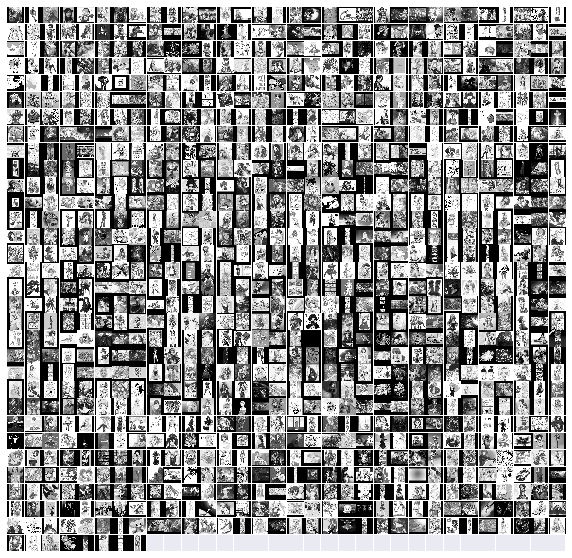

In [11]:
# plot the images of the dataset
show_images(images)

In [12]:
# reshape images 
reshaped_images = images.reshape(-1, n_features)

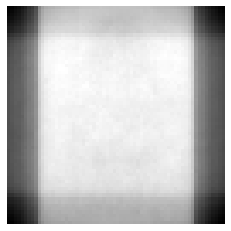

In [13]:
# get the mean image of the dataset
# minus this from each batch so to normalize them.
# this will help the values from going wild
mean_image = reshaped_images.mean(axis=0)

# flatten it
mean_image_reshaped = mean_image.reshape(resize_dim, resize_dim)

# inspect it
show_image(mean_image_reshaped)

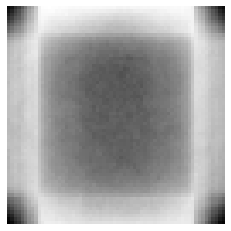

In [14]:
# get the standard deviation image
std_dev_image = reshaped_images.std(axis=0)

# flatten it
std_dev_image_reshaped = std_dev_image.reshape(resize_dim, resize_dim)

# inspect it
show_image(std_dev_image_reshaped)

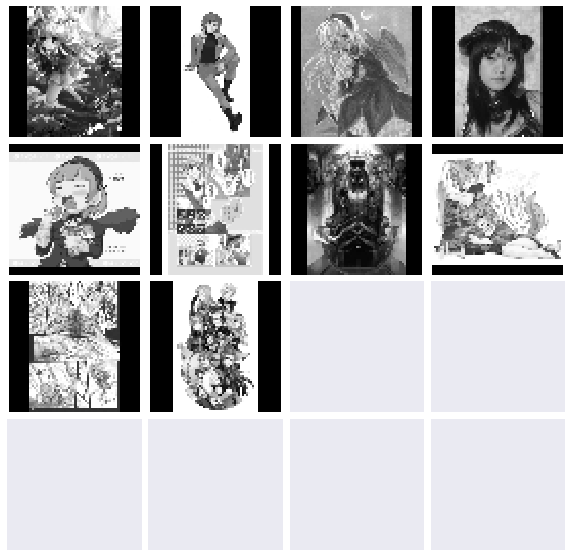

In [72]:
# test images to reconstruct
test_images = reshaped_images[:n_tests]

# reshape them
reshaped_test_images = test_images.reshape(-1, resize_dim, resize_dim)

# plot them
show_images(reshaped_test_images)

## 2. Build a generative model
Lets build an autoencoder

In [54]:
reset_default_graph()

In [55]:
# create a place holder for inputs
X = tf.placeholder(tf.float32, [None, n_features])

In [56]:
# Build the first half of the autoencoder which reduces dimensions at each layer
# copy X placeholder to current_input
current_input = X
n_input = n_features

# create a list to store each matrix created
Ws = []

# loop over the list of dimensions and create a layer
# layer_i = index of current element
# n_output = element
for layer_i, n_output in enumerate(dimensions):
    # use variable scope to encapsulate variables
    # prefix all variables created in this scope
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        
        # create a weight matrix of the shape [n_input, n_output]
        W = tf.get_variable(
                name='W',
                shape=[n_input, n_output],
                initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        
        # create bais vector of the shape [n_output]
        b = tf.get_variable(
                name='b',
                shape=[n_output],
                dtype=tf.float32,
                initializer=tf.constant_initializer(0.0))
        
        # multiply the layer input and the weight matrix
        # and add the bais
        h = tf.nn.bias_add(
                name='h',
                value=tf.matmul(current_input, W),
                bias=b)
        
        # use an activation function (RELU) on the output and set it to the input for the next layer
        current_input = tf.nn.relu(h)
        
        # store the weight matrix so that we can build the decoder
        Ws.append(W)
        
        # update the input dimensions with the current layer output
        n_input = n_output

In [57]:
# reverse the order of the weight matrices
Ws = Ws[::-1]

# reverse the order of the dimensions
# append on the original dimension on the end of the list
dimensions = dimensions[::-1][1:] + [n_features]

In [58]:
# loop over the list of dimensions and create a layer
# layer_i = index of current element
# n_output = element
for layer_i, n_output in enumerate(dimensions):
    # use variable scope to encapsulate variables
    # prefix all variables created in this scope
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        
        # grab the weight matrix fron the encoder and transpose it
        W = tf.transpose(Ws[layer_i])
        
        # create bais vector of the shape [n_output]
        b = tf.get_variable(
                name='b',
                shape=[n_output],
                dtype=tf.float32,
                initializer=tf.constant_initializer(0.0))
        
        # multiply the layer input and the weight matrix
        # and add the bais
        h = tf.nn.bias_add(
                name='h',
                value=tf.matmul(current_input, W),
                bias=b)
        
        # use an activation function (RELU) on the output and set it to the input for the next layer
        current_input = tf.nn.relu(h)
        
        # update the input dimensions with the current layer output
        n_input = n_output

In [59]:
# the current_input of the last layer is Y
Y = current_input

### Define cost function
Define the training signal.
This will be a cost function to measure the success of the network

In [60]:
# measure average difference across pixels
pixel_cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)

# measure mean across batches
cost = tf.reduce_mean(pixel_cost)

# use an Adam optimizer for training which tries to minimize cost
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## 3. Train the model

In [61]:
# create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0 0 1.06275
0 1 3.53928
0 2 1.06108
0 3 0.950144
0 4 0.841127
0 5 1.18292
0 6 1.14139
0 7 0.882459
0 8 0.757205
0 9 0.967474
0 10 1.00137
0 11 0.923514
0 12 1.04891
0 13 0.863101
0 14 0.891432
0 15 0.960025
0 16 0.900005
0 17 0.840429
0 18 0.834296
0 19 1.14494
0 20 0.787286
0 21 0.757431
0 22 1.07981
0 23 1.00809
0 24 0.835225
0 25 1.0144
0 26 0.808278
0 27 0.863062
0 28 1.0681
0 29 0.739373
0 30 0.627127
0 31 0.799043
0 32 0.826785
0 33 0.766735
0 34 1.01321
0 35 1.00583
0 36 0.774986
0 37 0.847546
0 38 0.91138
0 39 0.950096
0 40 0.847627
0 41 1.01183
0 42 0.77425
0 43 0.939393
0 44 0.896661
0 45 0.767731
0 46 0.901731
0 47 0.930351
0 48 1.04486
0 49 0.952436
0 50 0.865633
0 51 0.918253
0 52 0.6857
0 53 0.879218
0 54 0.898949
0 55 0.950629
0 56 0.866496
0 57 0.872375
0 58 0.988277
0 59 0.982119
0 60 0.819233
0 61 0.922827
0 62 0.786251
0 63 1.01128
0 64 0.741482
0 65 0.797549
0 66 0.894145
0 67 0.604173
0 68 0.859542
0 69 0.808528
0 70 0.850777
0 71 0.813888
0 72 0.788548
0 73 0.8578

5 97 0.670561
5 98 0.535297
5 99 0.902474
6 0 0.746281
6 1 0.899531
6 2 0.702582
6 3 0.77255
6 4 0.620696
6 5 0.928332
6 6 0.666479
6 7 0.692564
6 8 0.50232
6 9 0.987555
6 10 0.634952
6 11 0.710043
6 12 0.560613
6 13 0.703543
6 14 0.955511
6 15 0.524185
6 16 0.626233
6 17 0.658998
6 18 0.768164
6 19 0.760614
6 20 0.550442
6 21 0.734751
6 22 0.850765
6 23 0.697739
6 24 0.653819
6 25 0.595917
6 26 0.679568
6 27 0.793467
6 28 0.708777
6 29 0.714896
6 30 0.713727
6 31 0.621429
6 32 0.707838
6 33 0.74146
6 34 0.537914
6 35 0.802351
6 36 0.686819
6 37 0.681587
6 38 0.9894
6 39 0.756496
6 40 0.801633
6 41 0.729557
6 42 0.884079
6 43 0.826728
6 44 0.708973
6 45 0.518364
6 46 0.638257
6 47 0.778711
6 48 0.660319
6 49 0.769287
6 50 0.880888
6 51 0.632979
6 52 0.587898
6 53 0.583193
6 54 0.764417
6 55 0.765904
6 56 0.842522
6 57 0.779715
6 58 0.835079
6 59 0.877582
6 60 0.681318
6 61 0.917572
6 62 0.909944
6 63 0.610371
6 64 0.630886
6 65 0.711105
6 66 0.664082
6 67 0.840653
6 68 0.904135
6 69 0.

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


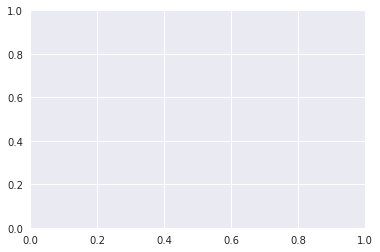

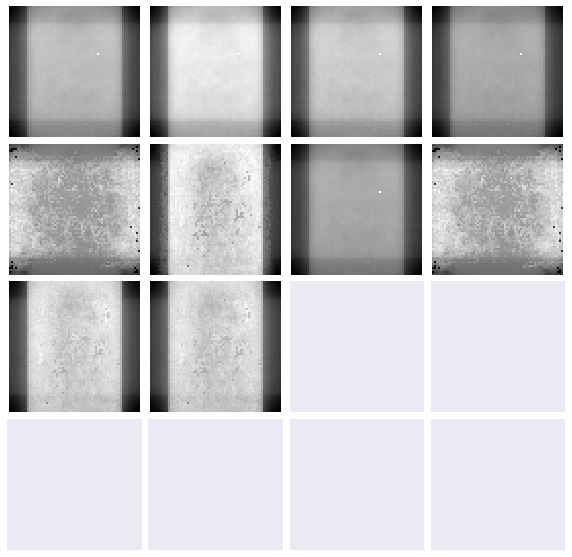

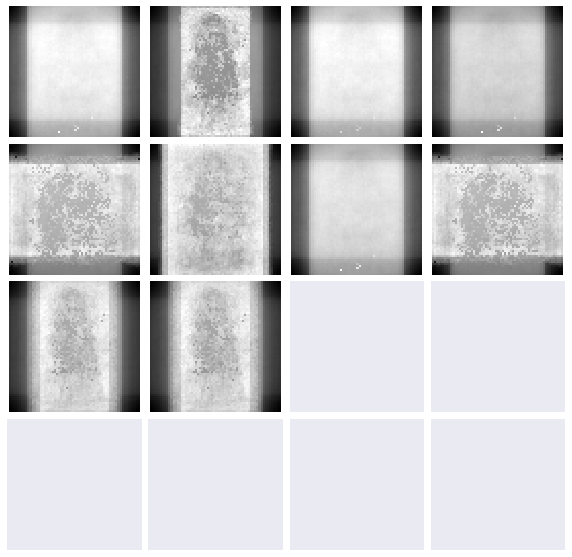

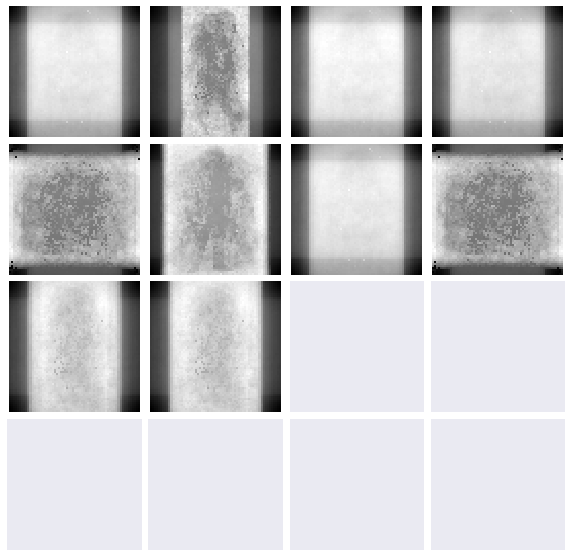

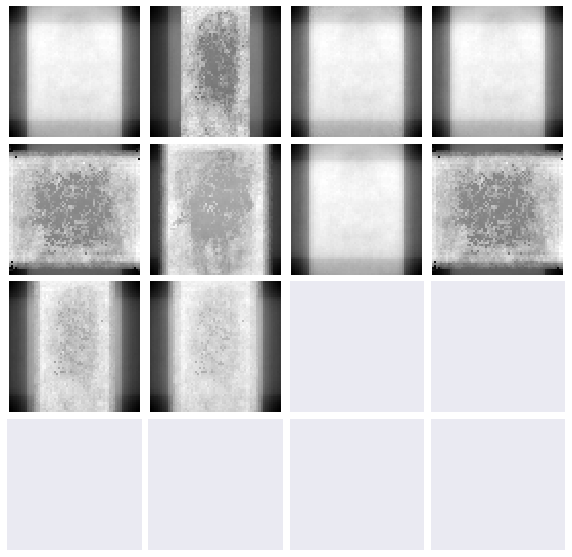

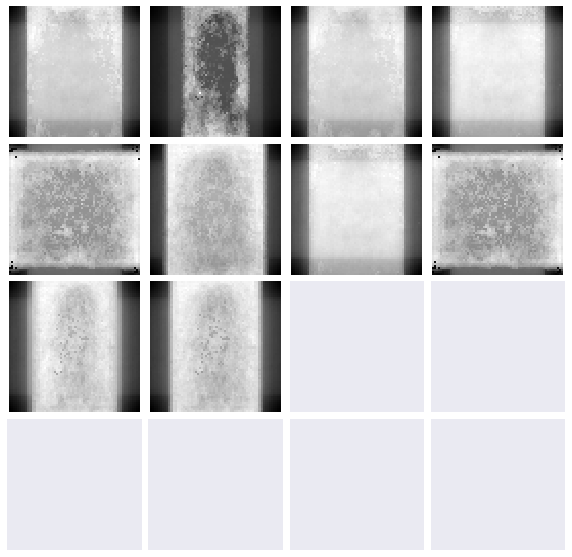

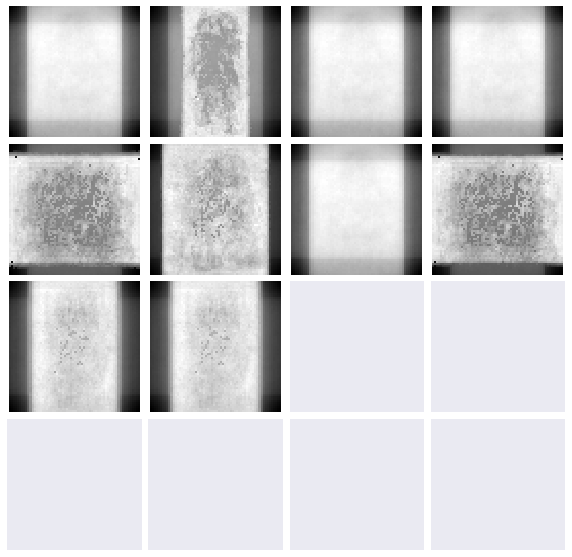

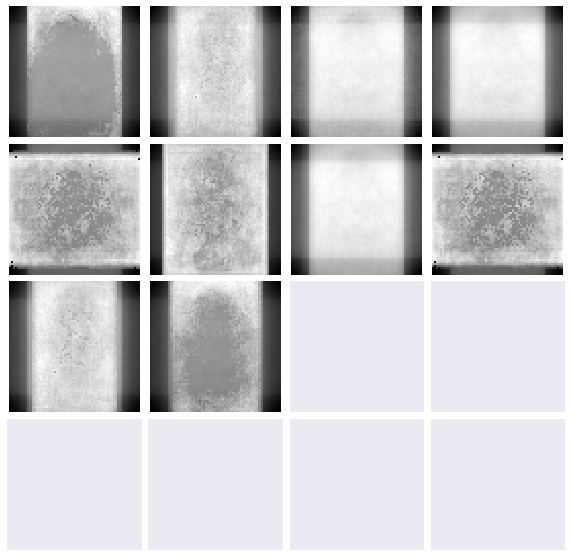

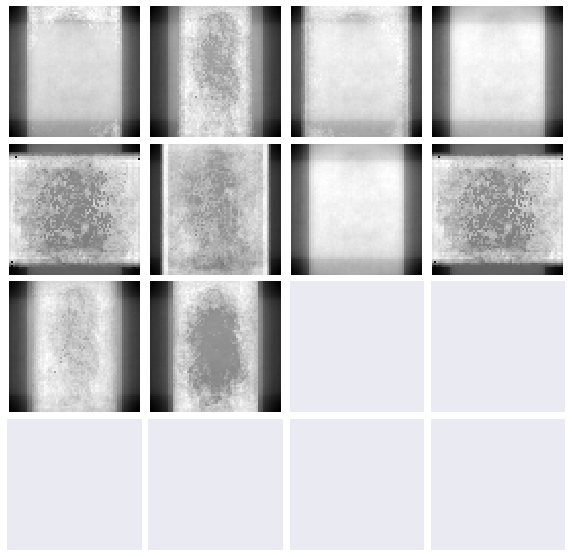

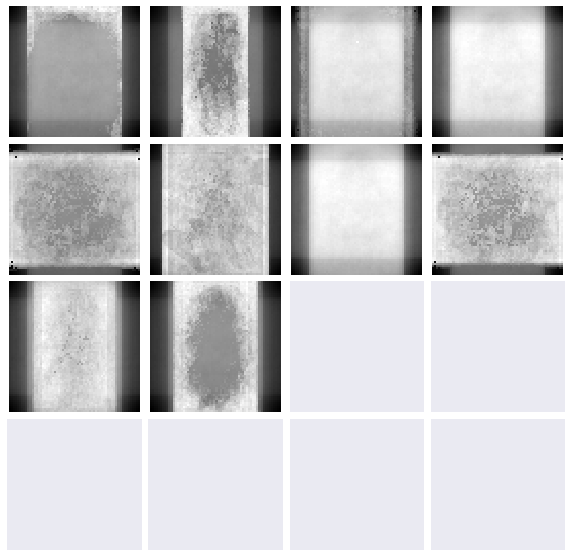

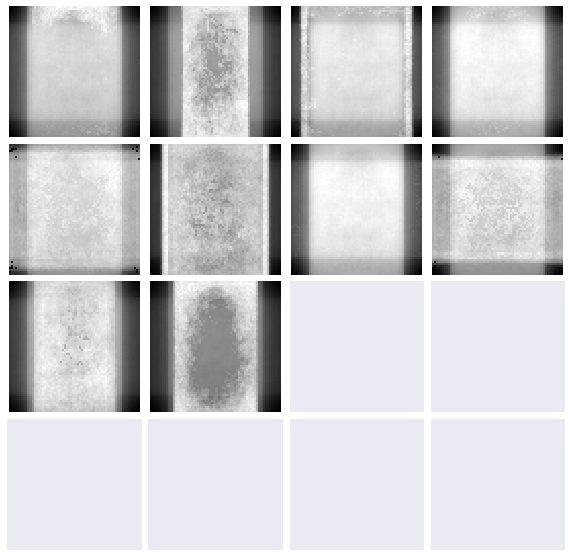

In [62]:
# train by running n batches for n epochs
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_i in range(n_batches):
        # get batch
        batch_X = get_batch(batch_size, reshaped_images)

        # preprocess batch
        preprocessed_batch = preprocess(batch_X, mean_image, std_dev_image)
        
        # train
        sess.run(optimizer, feed_dict={X: preprocessed_batch})

        # show cost per epoch
        print(epoch_i, batch_i, sess.run(cost, feed_dict={X: preprocessed_batch}))

    # preprocess the test images
    preprocessed_test_images = preprocess(test_images, mean_image, std_dev_image)

    # reconstruct the test images
    reconstructed_test_images = sess.run(Y, feed_dict={X: preprocessed_test_images})

    # deprocess the test images
    deprocessed_test_images = deprocess(reconstructed_test_images, mean_image, std_dev_image)
    
    # reshape them to the original shape and type
    reshaped_deprocessed_test_images = deprocessed_test_images.reshape(-1, resize_dim, resize_dim)

    # plot them results for this epoch
    show_images(reshaped_deprocessed_test_images)

## 4. Generate a new image
Use the trained model to generate a new image

In [63]:
# number of images to generate
n_new_images = 10

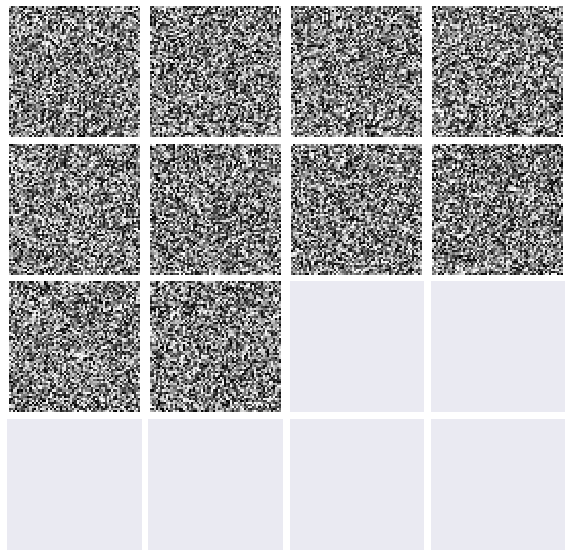

In [64]:
# generate using random numbers
np.random.RandomState(seed=0)
new_images = np.random.rand(n_new_images, resize_dim, resize_dim)

# flatten the images
reshaped_new_images = new_images.reshape(-1, n_features)

# view the image
show_images(new_images)

### Reconstruct without normalizing against training dataset

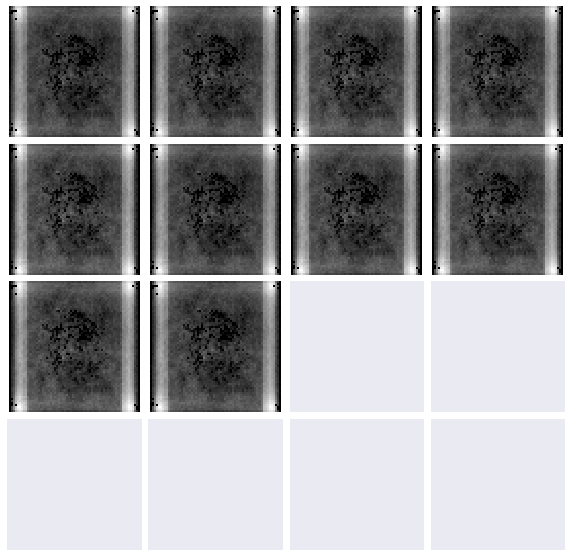

In [66]:
# reconstruct the example images
reconstructed_images = sess.run(Y, feed_dict={X: reshaped_new_images})

# reshape them to the original shape and type
reshaped_reconstructed_images = (reconstructed_images).reshape(-1, resize_dim, resize_dim)

# plot them
show_images(reshaped_reconstructed_images)

### Reconstruct with normalizing against training dataset

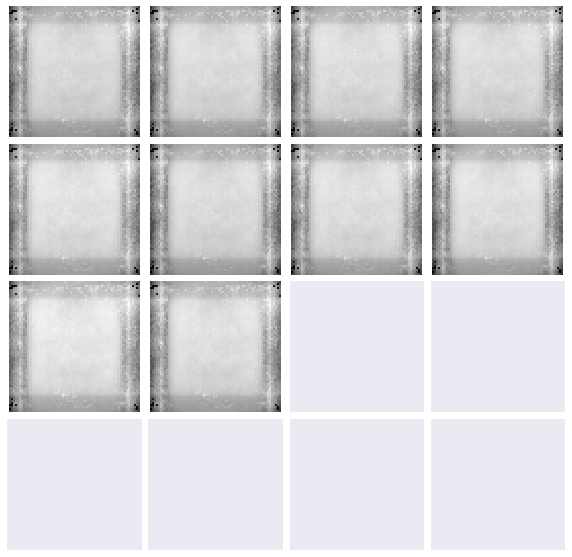

In [67]:
# preprocess batch
preprocessed_new_images = preprocess(reshaped_new_images, mean_image, std_dev_image)

# reconstruct the example images
reconstructed_images = sess.run(Y, feed_dict={X: preprocessed_new_images})

# deprocess the test images
deprocessed_new_images = deprocess(reconstructed_images, mean_image, std_dev_image)
    
# reshape them to the original shape and type
reshaped_deprocessed_images = deprocessed_new_images.reshape(-1, resize_dim, resize_dim)

# plot them
show_images(reshaped_deprocessed_images)

## 5. Transfer style to an image

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


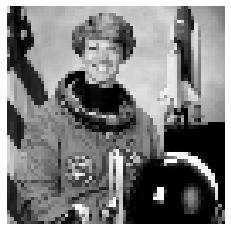

In [68]:
# grab an image
transfer_image = data.astronaut()

# resize the image and put it into gray scale
resized_transfer_image = gray_scale_resize(transfer_image, resize_dim)

# flatten the image
reshaped_transfer_image = resized_transfer_image.reshape(-1, n_features)

# display an image
show_image(resized_transfer_image)

### Reconstruct without normalizing against training dataset

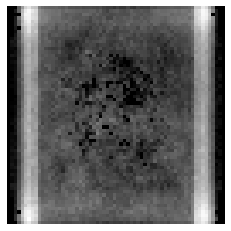

In [70]:
# reconstruct the example images
reconstructed_transfer_image = sess.run(Y, feed_dict={X: reshaped_transfer_image})

# reshape them to the original shape and type
reshaped_reconstructed_transfer_image = reconstructed_transfer_image.reshape(resize_dim, resize_dim)

# plot them
show_image(reshaped_reconstructed_transfer_image)

### Reconstruct with normalizing against training dataset

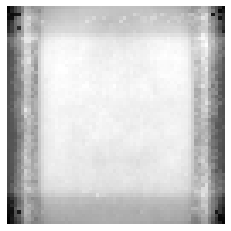

In [71]:
# preprocess batch
preprocessed_transfer_images = preprocess(reshaped_transfer_image, mean_image, std_dev_image)

# reconstruct the example images
reconstructed_transfer_image = sess.run(Y, feed_dict={X: preprocessed_transfer_images})

# deprocess the test images
deprocessed_transfer_images = deprocess(reconstructed_transfer_image, mean_image, std_dev_image)
  
# reshape them to the original shape and type
reshaped_deprocessed_transfer_image = deprocessed_transfer_images.reshape(resize_dim, resize_dim)

# plot them
show_image(reshaped_deprocessed_transfer_image)

## 6. Examine results

This does a much better job reconstructing the images than the PCA model. It still doesn't work so theres are few things we can do:
    - get more data
    - get better data
    
    
Lets explore a convolutional autoencoder first.